In [1]:
# using PlotlyJS
using Plots
using PyCall
using Printf
using LsqFit
using LinearAlgebra
using Statistics
# using Flux
using Random
using DualNumbers
using ForwardDiff
# using Distributed
# using Base.Threads
# using Pkg
# using Optim
gr()  

Plots.GRBackend()

In [58]:
include("ABC.jl")

hartreeToWavenumberConversion::Float64 = 2.194746354e5
convertToRadians::Float64 = pi/180

# inputFileName::String = "HOCl-InitialFit"
# inputFileName::String = "HOCl-CBS+HL-rOH-1D"
# inputFileName::String = "HOCl-CBS+HL-rOCl-1D"
# inputFileName::String = "HOCl-CBS+HL-alpha-1D"
# inputFileName::String = "HOCl-VQZ+HL-alpha-1D"
# inputFileName::String = "HOCl-CBS+HL-InitialFit"
inputFileName::String = "HOCl-CBS+HL-Chebyshev"
potentialInputFilePath::String = inputFileName*".inp"

keywords::Vector{String} = ["structural", "linear", "grid"]
inputBlocks::Vector{Vector{String}} = []
open(potentialInputFilePath, "r") do potentialInputFile::IOStream
    input::Vector{String} = readlines(potentialInputFile)
    addToBlock::Bool = false
    for keyword in keywords
        newBlock::Vector{String} = []
        for line in input
            if lowercase(line) == lowercase(keyword)
                addToBlock = true
            elseif lowercase(line) == "end"
                addToBlock = false
            end
            if addToBlock
                push!(newBlock, line)
            end
        end
        push!(inputBlocks, newBlock)
    end
end

structuralParameterBlock::Vector{String} = inputBlocks[1][2:end]
numberOfStructuralParameters::Int64 = size(structuralParameterBlock)[1] - 1
structuralParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(structuralParameterBlock, r"\s+")
numberOfMorseParameters::Int64 = parse(Int64, structuralParameterBlockSplit[1][2])
numberOfEquilibriumParameters::Int64 = numberOfStructuralParameters - numberOfMorseParameters
numberOfModes::Int64 = size(structuralParameterBlockSplit[2])[1] - 3
numberOfAtoms::Int64 = (numberOfModes + 6)/3
numberOfStretches::Int64 = numberOfAtoms - 1
numberOfBondAngles::Int64 = numberOfAtoms - 2
numberOfDihedrals::Int64 = numberOfAtoms - 3

structuralParameters::Vector{Float64} = zeros(numberOfStructuralParameters)
structuralParameterLabels::Vector{String} = []
structuralPowers::Matrix{Int64} = zeros(numberOfStructuralParameters, numberOfModes)
structuralParametersOn::Vector{Int64} = zeros(numberOfStructuralParameters)
for i in 1:numberOfStructuralParameters
    structuralParameters[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end])
    push!(structuralParameterLabels, String(structuralParameterBlockSplit[i + 1][1]))
    structuralPowers[i, :] = parse.(Int64, structuralParameterBlockSplit[i + 1][2:end-2])
    structuralParametersOn[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end - 1])
end

structuralParameters::Vector{Float64} = convertAnglesToRadians(structuralParameters)
indicesOfStructuralParametersOn::Vector{Int64} = findall(>(0), structuralParametersOn)

linearParameterBlock::Vector{String} = inputBlocks[2][2:end]
numberOfLinearParameters::Int64 = size(linearParameterBlock)[1]
linearParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(linearParameterBlock, r"\s+")

linearParameters::Vector{Float64} = zeros(numberOfLinearParameters)
linearParameterLabels::Vector{String} = []
linearPowers::Matrix{Int64} = zeros(numberOfLinearParameters, numberOfModes)
linearPowersTotal::Vector{Int64} = zeros(numberOfLinearParameters)
linearParametersOn::Vector{Int64} = zeros(numberOfLinearParameters)

for i in 1:numberOfLinearParameters
    linearParameters[i] = parse(Float64, linearParameterBlockSplit[i][end])
    push!(linearParameterLabels, String(linearParameterBlockSplit[i][1]))
    linearPowers[i, :] = parse.(Int64, linearParameterBlockSplit[i][2:end-2])
    linearPowersTotal[i] = sum(linearPowers[i, :])
    linearParametersOn[i] = parse(Float64, linearParameterBlockSplit[i][end - 1])
end

# Reduce expansion order
maxExpansionOrder::Int64 = 12
indicesBelowExpansionOrderThreshold::Vector{Int64} = findall(<=(maxExpansionOrder), linearPowersTotal)
linearPowersTotal = linearPowersTotal[indicesBelowExpansionOrderThreshold]
linearParameters = linearParameters[indicesBelowExpansionOrderThreshold]
linearPowers = linearPowers[indicesBelowExpansionOrderThreshold, :] 
linearParametersOn = linearParametersOn[indicesBelowExpansionOrderThreshold]
numberOfLinearParameters = length(linearParameters)

# Define Chebyshev polyonmials for construction of basis
chebyshevPolynomials::Vector{Function} = [
    x -> 1,
    x -> x,
    # x -> 2*x^2 - 1,
    # x -> 4*x^3 - 3*x,
    # x -> 8*x^4 - 8*x^2 + 1,
    # x -> 16*x^5 - 20*x^3 + 5*x,
    # x -> 32*x^6 - 48*x^4 + 18*x^2 - 1,
    # x -> 64*x^7 - 112*x^5 + 56*x^3 - 7*x,
    # x -> 128*x^8 - 256*x^6 + 160*x^4 - 32*x^2 + 1
]
for i in 3:maxExpansionOrder+1
    push!(chebyshevPolynomials, x -> 2*x*chebyshevPolynomials[i-1](x) - chebyshevPolynomials[i-2](x))
end
# Note Julia indexing starts from 1 so chebyshevPolynomials[n] is actually T_n-1 and so forth!

allParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)
allParameterLabels::Vector{String} = vcat(structuralParameterLabels, linearParameterLabels)
allPowers::Matrix{Int64} = vcat(structuralPowers, linearPowers)
allParametersOn::Vector{Int64} = vcat(structuralParametersOn, linearParametersOn)
numberOfParameters::Int64 = length(allParameters)
 
gridBlock::Vector{String} = inputBlocks[3][2:end]
numberOfGridPoints::Int64 = size(gridBlock)[1] 
gridBlockSplit::Vector{Vector{SubString{String}}} = split.(gridBlock, r"\s+")

grid::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
gridValenceCoordinates::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
energies::Vector{Float64} = zeros(numberOfGridPoints)

for i in 1:numberOfGridPoints
    grid[i, :]  = parse.(Float64, gridBlockSplit[i][1:numberOfModes])
    gridValenceCoordinates[i, :] = defineInternalCoordinates(grid[i, :])
    energies[i] = parse(Float64, gridBlockSplit[i][numberOfModes+1])
end

referenceGeometry::Vector{Float64} = gridValenceCoordinates[1, :] 

# energies = energies.*hartreeToWavenumberConversion
# minimumEnergy::Float64 = minimum(energies)
println()
# @printf("%12.10f \n", minimumEnergy)
# energies = energies.-minimumEnergy

energyMaximum::Float64 = 1.0e4
indicesBelowEnergyThreshold::Vector{Int64} = findall(<(energyMaximum), energies)
energies = energies[indicesBelowEnergyThreshold]
gridValenceCoordinates = gridValenceCoordinates[indicesBelowEnergyThreshold, :]
grid = grid[indicesBelowEnergyThreshold, :]
numberOfGridPoints = length(energies)

# Weight factor by Partridge and Schwenke
function computeWeightOfPoint(energy::Float64, energyThreshold=20000.0::Float64, energyMax=10000.0::Float64)::Float64
    weight::Float64 = (tanh(−0.0006*(energy - energyThreshold)) + 1.002002002)/2.002002002
    if energy > energyMax
        weight = weight/(0.0001*energy)
    else
        weight = weight/(0.0001*energyMax)
    end
    return weight
end

weights::Vector{Float64} = computeWeightOfPoint.(energies)
weightsSqrt::Vector{Float64} = sqrt.(weights)

function defineXiGrid(gridValenceCoordinates::Matrix{Float64}, structuralParameters)
    numberOfGridPoints::Int64 = size(gridValenceCoordinates)[1]
    T::DataType = eltype(structuralParameters)
    xiGrid::Matrix{T} = zeros(numberOfGridPoints, numberOfModes)
    for i in 1:numberOfGridPoints
        xiGrid[i, :] = defineXiCoordinates(gridValenceCoordinates[i, :], structuralParameters)
    end
    return xiGrid
end

function defineXiGridScaled(gridValenceCoordinates::Matrix{Float64}, structuralParameters)
    numberOfGridPoints::Int64 = size(gridValenceCoordinates)[1]
    T::DataType = eltype(structuralParameters)
    xiGrid::Matrix{T} = zeros(numberOfGridPoints, numberOfModes)
    for i in 1:numberOfGridPoints
        xiGrid[i, :] = defineXiCoordinatesScaled(gridValenceCoordinates[i, :], structuralParameters)
    end
    return xiGrid
end




# For range 1 to -1
function rescaleXiGrid(xiGrid)
    xiMaxima = maximum(xiGrid, dims=1)[1, :]
    xiMinima = minimum(xiGrid, dims=1)[1, :]
    xiGrid = (2*xiGrid .- (xiMaxima .+ xiMinima)')./(xiMaxima .- xiMinima)'
    return xiGrid
end

# For unit variance
# function rescaleXiGrid(xiGrid)
#     xistd = std(xiGrid, dims=1)[1, :]
#     ximean = mean(xiGrid, dims=1)[1, :]
#     xiGrid = (xiGrid .- (ximean)')./(xistd)'
#     return xiGrid
# end


function defineChebyshevBasis(xiGrid)
    numberOfGridPoints::Int64 = size(xiGrid)[1]
    T::DataType = eltype(xiGrid)
    xiMatrix::Matrix{T} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        for j in 1:numberOfLinearParameters
            xiMatrix[i, j] = chebyshevPolynomials[linearPowers[j, 1]+1](xiGrid[i, 1])*chebyshevPolynomials[linearPowers[j, 2]+1](xiGrid[i, 2])*chebyshevPolynomials[linearPowers[j, 3]+1](xiGrid[i, 3])
            # if linearPowers[j, 1] != linearPowers[j, 2]
            #     xiMatrix[i, j] += chebyshevPolynomials[linearPowers[j, 1]+1](xiGrid[i, 2])*chebyshevPolynomials[linearPowers[j, 2]+1](xiGrid[i, 1])*chebyshevPolynomials[linearPowers[j, 3]+1](xiGrid[i, 3])
            # end
        end
    end
    return xiMatrix
end

function definePowersGrid(xiGrid)
    numberOfGridPoints::Int64 = size(xiGrid)[1]
    T::DataType = eltype(xiGrid)
    xiMatrix::Matrix{T} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        for j in 1:numberOfLinearParameters
            xiMatrix[i, j] = xiGrid[i, 1]^linearPowers[j, 1]*xiGrid[i, 2]^linearPowers[j, 2]*xiGrid[i, 3]^linearPowers[j, 3]
            # if linearPowers[j, 1] != linearPowers[j, 2]
            #     xiMatrix[i, j] += xiGrid[i, 2]^linearPowers[j, 1]*xiGrid[i, 1]^linearPowers[j, 2]*xiGrid[i, 3]^linearPowers[j, 3]
            # end
        end
    end
    return xiMatrix
end

function solveLinearRegression(gridValenceCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, structuralParameterIndex, structuralParameterForDerivative, λ::Float64 = 1e-7)
    T::DataType = typeof(structuralParameterForDerivative)
    numberOfGridPoints::Int64 = length(energies)
    structuralParametersInLossFunction::Vector{T} = copy(structuralParameters)
    structuralParametersInLossFunction[structuralParameterIndex] = structuralParameterForDerivative
    xiGrid = defineXiGrid(gridValenceCoordinates, structuralParametersInLossFunction)
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix = defineChebyshevBasis(xiGrid)
    xiMatrix = definePowersGrid(xiGrid)
    weightsSqrt::Vector{Float64} = sqrt.(weights)
    weightedXiMatrix = xiMatrix .* weightsSqrt
    weightedEnergies = energies .* weightsSqrt
    tikhonovMatrix::Matrix{Float64} = λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters)
    linearParametersOfFit = (weightedXiMatrix'*weightedXiMatrix + tikhonovMatrix)\ (weightedXiMatrix'*weightedEnergies)
    computedEnergies::Vector{T} = xiMatrix*linearParametersOfFit
    residuals::Vector{T} = energies .- computedEnergies
    loss::T = (sum(weights.*residuals.^2) + sum(λ.*linearParametersOfFit.^2))/numberOfGridPoints
    return loss
end

function computeLossForwardDiff(gridValenceCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, structuralParameters, λ::Float64 = 1e-7)
    T::DataType = eltype(structuralParameters)
    numberOfGridPoints::Int64 = length(energies)
    xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix = defineChebyshevBasis(xiGrid)
    xiMatrix = definePowersGrid(xiGrid)
    computedEnergies::Vector{T} = xiMatrix*linearParameters
    residuals::Vector{T} = energies .- computedEnergies
    loss::T = (sum(weights.*residuals.^2) + sum(λ.*linearParameters.^2))/numberOfGridPoints
    return loss
end

function computeResdidualForwardDiff(gridValenceCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, structuralParameters)
    T::DataType = eltype(structuralParameters)
    numberOfGridPoints::Int64 = length(energies)
    xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
    xiMatrix = definePowersGrid(xiGrid)
    weightedXiMatrix = xiMatrix .* weightsSqrt
    weightedEnergies = energies .* weightsSqrt
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix = defineChebyshevBasis(xiGrid)
    computedEnergies::Vector{T} = weightedXiMatrix*linearParameters
    residuals::Vector{T} = weightedEnergies .- computedEnergies
    return residuals
end

function computeLoss(xiMatrix::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, λ::Float64 = 1e-7)
    numberOfGridPoints::Int64 = length(energies)
    computedEnergies::Vector{Float64} = xiMatrix*linearParameters
    residuals::Vector{Float64} = energies .- computedEnergies
    loss::Float64 = (sum(weights.*residuals.^2) + λ*sum(linearParameters.^2))/numberOfGridPoints
    return loss
end

function computeJacobianOfResiduals(xiMatrix::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64})
    numberOfGridPoints::Int64 = length(energies)
    weightedXiMatrix = xiMatrix .* weightsSqrt
    weightedEnergies = energies .* weightsSqrt
    # computedEnergies::Vector{Float64} = weightedXiMatrix*linearParameters
    jacobian::Matrix{Float64} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        for j in 1:numberOfLinearParameters
            jacobian[i, j] = weightedEnergies[i] - weightedXiMatrix[i, j]
        end
    end
    return jacobian
end

function computeGradient(xiMatrix::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, λ::Float64 = 1e-7)
    numberOfGridPoints::Int64 = length(energies)
    computedEnergies::Vector{Float64} = xiMatrix*linearParameters
    residuals::Vector{Float64} = energies .- computedEnergies
    gradientVector::Vector{Float64} = 2*(-xiMatrix'*(weights.*residuals) .+ λ.*linearParameters)/numberOfGridPoints
    return gradientVector
end

function computeHessian(xiMatrix::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, λ::Float64 = 1e-7)
    numberOfGridPoints::Int64 = length(energies)
    weightsSqrt::Vector{Float64} = sqrt.(weights)
    weightedXiMatrix = xiMatrix .* weightsSqrt
    hessian::Matrix{Float64} = 2*(weightedXiMatrix'*weightedXiMatrix .+ λ*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters))/numberOfGridPoints
    return hessian
end


structuralParameterBounds::Vector{Vector{Float64}} = [
    [0.96446195 - 0.2, 0.96446195 + 0.2],
    [1.68888476 - 0.2, 1.68888476 + 0.2],
    [(103.000000 - 1.5)*convertToRadians, (103.000000 + 1.5)*convertToRadians],
    [1.0, 5.0],
    [1.0, 5.0],
]

# xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
xiGrid = defineXiGridScaled(gridValenceCoordinates, structuralParameters)
# xiGrid = rescaleXiGrid(xiGrid)
# xiGrid = defineXiCoordinatesScaled(xiGrid)
xiMatrix::Matrix{Float64} = defineChebyshevBasis(xiGrid)
# xiMatrix::Matrix{Float64} = definePowersGrid(xiGrid)

# weightedXiMatrix::Matrix{Float64} = xiMatrix .* weightsSqrt
# weightedEnergies::Vector{Float64} = energies .* weightsSqrt

learningRateStructural::Float64 = 1.0
learningRateLinear::Float64 = 1.0
ϵ::Float64 = 1e-4 # Regulate weights for robust fitting
λ::Float64 = 1e-8 # Tikhonov Regularization parameter
epochs::Int64 = 200
for epoch in 1:epochs
    # structuralParameterGradient::Vector{Float64} = ForwardDiff.gradient(structuralParameters -> computeLossForwardDiff(gridValenceCoordinates, energies, weights, structuralParameters, λ), structuralParameters)
    # structuralParameterHessian::Matrix{Float64} = ForwardDiff.hessian(structuralParameters -> computeLossForwardDiff(gridValenceCoordinates, energies, weights, structuralParameters, λ), structuralParameters)
    # structuralParameters -= learningRateStructural*(structuralParameterHessian\structuralParameterGradient).*structuralParametersOn
    # xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
    xiGrid = defineXiGridScaled(gridValenceCoordinates, structuralParameters)
    # xiGrid = rescaleXiGrid(xiGrid)
    # xiMatrix::Matrix{Float64} = definePowersGrid(xiGrid)
    xiMatrix::Matrix{Float64} = defineChebyshevBasis(xiGrid)
    # weightsSqrt::Vector{Float64} = sqrt.(weights)
    weightedXiMatrix = xiMatrix .* weightsSqrt
    weightedEnergies = energies .* weightsSqrt
    # linearParameters = (weightedXiMatrix'*weightedXiMatrix + λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters))\ (weightedXiMatrix'*weightedEnergies)
    # diag(computeHessian(xiMatrix, energies, weights, λ))
    # hessianLinear::Matrix{Float64} = computeHessian(xiMatrix, energies, weights, λ)
    # jacobianLinear::Vector{Float64} = computeGradient(xiMatrix, energies, weights, λ)
    # jacobianLinear::Matrix{Float64} = computeJacobianOfResiduals(xiMatrix, energies, weights)
    linearParameters -= learningRateLinear*((weightedXiMatrix'*weightedXiMatrix .+ λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters)*linearPowersTotal.^2)\(-weightedXiMatrix'*(weightedEnergies .- weightedXiMatrix*linearParameters))).*linearParametersOn
    # tikhonovMatrix::Matrix{Float64} = λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters)
    # linearParametersOfFit = (weightedXiMatrix'*weightedXiMatrix + tikhonovMatrix)\ (weightedXiMatrix'*weightedEnergies)
    # linearParameters -= learningRateLinear*((jacobianLinear'*jacobianLinear .+ λ.*Matrix(1I, numberOfLinearParameters, numberOfLinearParameters)*linearPowersTotal.^2)\(jacobianLinear'*(weightedEnergies .- weightedXiMatrix*linearParameters))).*linearParametersOn
    # linearParameters -= learningRateLinear.*(hessianLinear\jacobianLinear).*linearParametersOn
    # Q, R = qr(Diagonal(weightsSqrt)*xiMatrix)
    # linearParameters = R \ (Matrix(Q)' * (energies.*weightsSqrt))
    # structuralParametersJacobian::Matrix{Float64} = ForwardDiff.jacobian(structuralParameters -> computeResdidualForwardDiff(gridValenceCoordinates, energies, weights, structuralParameters), structuralParameters)[:, indicesOfStructuralParametersOn]
    # structuralParameters[indicesOfStructuralParametersOn] -= learningRateStructural*(structuralParametersJacobian'*structuralParametersJacobian)\(structuralParametersJacobian'*computeResdidualForwardDiff(gridValenceCoordinates, energies, weights, structuralParameters))
    # structuralParameters = map((parameter, bound) -> clamp(parameter, bound[1], bound[2]), structuralParameters, structuralParameterBounds)
    residuals::Vector{Float64} = energies .- xiMatrix*linearParameters
    println("Epoch $(epoch), Loss = ", sum(weights.*residuals.^2)/numberOfGridPoints)
    weights = 1 ./ (residuals.^2 .+ ϵ)
    weightsSqrt::Vector{Float64} = sqrt.(weights)
end


# xiGrid = defineXiGrid(gridValenceCoordinates, structuralParameters)
# xiGrid = rescaleXiGrid(xiGrid)
xiGrid = defineXiGridScaled(gridValenceCoordinates, structuralParameters)
xiMatrix::Matrix{Float64} = defineChebyshevBasis(xiGrid)
# xiMatrix::Matrix{Float64} = definePowersGrid(xiGrid)
# Q, R = qr(Diagonal(weightsSqrt)*testXiMatrix)
# linearParameters = R \ (Matrix(Q)' * (energies.*weightsSqrt))
# linearParameters
# println(solveLinearRegressionForForwardDiff(gridValenceCoordinates, energies, weights, 1, structuralParameters[1]))

sortedEnergyOrderingIndices::Vector{Int64} = sortperm(energies)
energies = energies[sortedEnergyOrderingIndices]
grid = grid[sortedEnergyOrderingIndices, :]
xiMatrix = xiMatrix[sortedEnergyOrderingIndices, :]

computedEnergies::Vector{Float64} = xiMatrix*linearParameters
residuals::Vector{Float64} = energies .- computedEnergies

structuralParameters = convertAnglesToDegrees(structuralParameters)

fittedParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)
weights = computeWeightOfPoint.(energies)

open(inputFileName*".out", "w") do outputFile::IOStream
    println(outputFile, "New model:")
    for i in 1:numberOfParameters
        @printf(outputFile, "f   %4.0f %4.0f %4.0f  %12.12f\n", allPowers[i, 1], allPowers[i, 2], allPowers[i, 3], fittedParameters[i])
    end
    println(outputFile, )
    println(outputFile, "Grid of energies:")
    for i in 1:numberOfGridPoints
        @printf(outputFile, "%12.8f %12.8f %12.8f  %12.12f %12.12f %12.12f %12.12f\n", grid[i, 1], grid[i, 2], grid[i, 3],  energies[i], computedEnergies[i], residuals[i], weights[i])
    end
end
weightedRms::Float64 = sqrt(mean(weights.*residuals.^2))
println(weightedRms)


Epoch 1, Loss = 23.495533077047323
Epoch 2, Loss = 0.9253647186510046
Epoch 3, Loss = 7.377435018410351
Epoch 4, Loss = 1.0450758546236276
Epoch 5, Loss = 0.9594814970987258
Epoch 6, Loss = 1.3278629850015953
Epoch 7, Loss = 1.0513255461700584
Epoch 8, Loss = 1.601217199468561
Epoch 9, Loss = 0.9354519197983435
Epoch 10, Loss = 1.0821874536395553
Epoch 11, Loss = 1.0006661887547912
Epoch 12, Loss = 1.845166174582031
Epoch 13, Loss = 1.08197571092273
Epoch 14, Loss = 1.0850379136922494
Epoch 15, Loss = 0.9480140126722031
Epoch 16, Loss = 1.1296184255584032
Epoch 17, Loss = 356.6582870698915
Epoch 18, Loss = 1.0505367140679984
Epoch 19, Loss = 0.9502672735150652
Epoch 20, Loss = 1.3840722695309005
Epoch 21, Loss = 0.921194831747109
Epoch 22, Loss = 0.9515912299260034
Epoch 23, Loss = 0.9266208439332777
Epoch 24, Loss = 8.375209785690872
Epoch 25, Loss = 0.9794963749899327
Epoch 26, Loss = 0.9122882888570663
Epoch 27, Loss = 1.3614280481636456
Epoch 28, Loss = 0.9838030167361684
Epoch 29

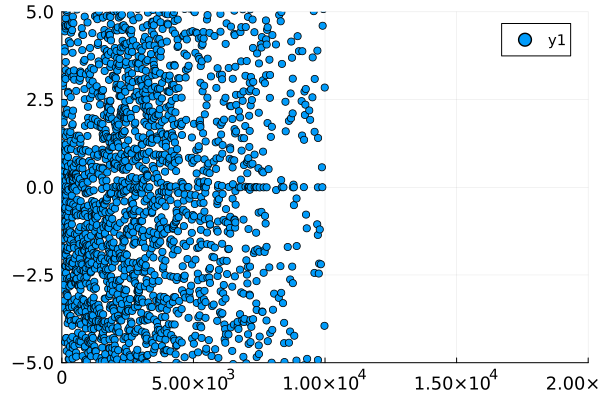

In [55]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
    xlimits=(0,20000),
    ylimits=(-5, 5)
)

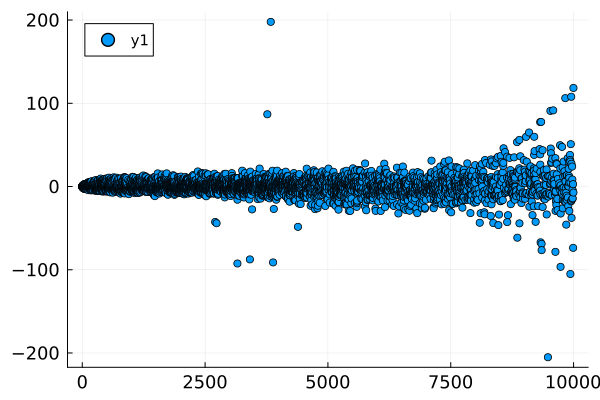

In [56]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
)

rOH 8th Order a1 = 1.2 does alright

In [7]:
maximum(xiGrid[:, 3])

0.5798081856491297

In [224]:
minimum(xiGrid)

NaN

In [223]:
maximum(xiMatrix[:, 2])

1.0

In [208]:
xiMatrix

3948×286 Matrix{Float64}:
 1.0  -0.0355436  -0.997473   0.106451   …   0.0594965    0.00368119
 1.0  -0.025473   -0.998702   0.0763529      0.0427921    0.00259039
 1.0  -0.0355436  -0.997473   0.106451       0.0597096    0.00361448
 1.0  -0.0355436  -0.997473   0.106451       0.0582637    0.00401244
 1.0  -0.0194129  -0.999246   0.0582093      0.0313288    0.0023006
 1.0  -0.0355436  -0.997473   0.106451   …   0.0602455    0.00342742
 1.0  -0.0355436  -0.997473   0.106451       0.0575637    0.00416982
 1.0  -0.0437714  -0.996168   0.130979       0.0735316    0.00445119
 1.0  -0.0355436  -0.997473   0.106451       0.058346     0.00399726
 1.0  -0.0355436  -0.997473   0.106451       0.0613941    0.00294751
 ⋮                                       ⋱                ⋮
 1.0   0.396756   -0.68517   -0.940446       0.0367951   -0.132651
 1.0  -0.566848   -0.357367   0.971993   …  -0.200051    -0.197586
 1.0   0.839473    0.40943   -0.152062      -0.605018    -0.270583
 1.0  -0.0355436  -0.997

In [210]:
minimum(xiMatrix)

-1.9999687024203479

In [211]:
maximum(xiMatrix)

1.9998748113679123

In [31]:
chebyshevPolynomials[3](1)

MethodError: MethodError: no method matching *(::Int64, ::var"#184#186")

Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:578
  *(::T, !Matched::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}
   @ Base int.jl:88
  *(::Union{Int16, Int32, Int64, Int8}, !Matched::BigInt)
   @ Base gmp.jl:552
  ...


In [8]:
linearParameters

165-element Vector{Float64}:
 -325474.47840196505
 -308699.31812338484
 -308867.4396701997
 -132318.27711645502
  -29736.17885865942
   -2183.187235623795
    -618.1301194928549
      26.111040201067276
      20.923817648856996
       1.0887479118096463e6
       ⋮
   17817.445502134608
  -32264.328209125386
   -9142.509885710024
  -55846.032168431724
   33075.836378867876
 -183217.27573160292
   12265.70926523196
  -15947.405229883681
   51027.15122402614

In [9]:
xiGrid

3948×3 Matrix{Float64}:
  0.387771    0.257251  -0.122277
  0.387771    0.258477  -0.114819
  0.387771    0.258477  -0.122277
  0.387771    0.250957  -0.122277
  0.387771    0.246951  -0.110332
  0.392933    0.25421   -0.122277
  0.387771    0.247818  -0.122277
  0.387771    0.258477  -0.12837
  0.383431    0.258477  -0.122277
  0.394837    0.258477  -0.122277
  ⋮                     
  0.389201    0.590059   0.197859
  0.0602145   0.243363  -0.51573
  0.331682    0.339907   0.52571
  0.682376    0.258477  -0.122277
  0.10389     0.549964  -0.122277
  0.387771   -0.309287  -0.283568
  0.135881    0.258477   0.454042
 -0.0107933   0.235964  -0.174665
  0.419527    0.267728  -0.829733